# Notebook 3: Collaborative Filtering
# Amazon Beauty Products - Recommendation System

In [37]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from src.models import UserBasedCF, ItemBasedCF, MatrixFactorizationALS, evaluate_model, recommend_for_user
from src.visualization import plot_model_comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. TẢI DỮ LIỆU ĐÃ XỬ LÝ

In [38]:
print("--- Loading Processed Data ---")

train_sparse = load_npz('../data/processed/train_matrix_sparse.npz')
val_sparse = load_npz('../data/processed/val_matrix_sparse.npz')
test_sparse = load_npz('../data/processed/test_matrix_sparse.npz')

idx_to_product = np.load('../data/processed/idx_to_product.npy', allow_pickle=True).item()
idx_to_user = np.load('../data/processed/idx_to_user.npy', allow_pickle=True).item()
user_to_idx = np.load('../data/processed/user_to_idx.npy', allow_pickle=True).item()

print(f"Train shape: {train_sparse.shape}")
print(f"Val shape:   {val_sparse.shape}")
print(f"Test shape:  {test_sparse.shape}")

--- Loading Processed Data ---
Train shape: (761, 608)
Val shape:   (761, 608)
Test shape:  (761, 608)


### 2.1 USER-BASER CF

In [39]:
all_results = []

print("\n>>> Running User-Based CF...")
user_cf = UserBasedCF(top_k=50)
user_cf.fit(train_sparse)
user_preds = user_cf.predict_all()
res_user = evaluate_model(user_preds, val_sparse, test_sparse, train_sparse, "User-Based CF (k=50)", dataset='validation')
all_results.append(res_user)


>>> Running User-Based CF...

=== Training User-Based CF (k=50) ===
✓ Training complete in 0.05s

Evaluation: User-Based CF (k=50) (VALIDATION)
  RMSE: 0.9400
  MAE:  0.6710
  P@5:  0.0059, R@5: 0.0099, F1@5: 0.0074
  P@10: 0.0072, R@10: 0.0246, F1@10: 0.0111


### 2.2 ITEM-BASED CF

In [40]:
print("\n>>> Running Item-Based CF...")
item_cf = ItemBasedCF(top_k=50)
item_cf.fit(train_sparse)
item_preds = item_cf.predict_all()
res_item = evaluate_model(item_preds, val_sparse, test_sparse, train_sparse, "Item-Based CF (k=50)", dataset='validation')
all_results.append(res_item)



>>> Running Item-Based CF...

=== Training Item-Based CF (k=50) ===
✓ Training complete in 0.07s
  Similarity matrix: 21,753 entries

Evaluation: Item-Based CF (k=50) (VALIDATION)
  RMSE: 0.9661
  MAE:  0.6624
  P@5:  0.0095, R@5: 0.0140, F1@5: 0.0113
  P@10: 0.0089, R@10: 0.0267, F1@10: 0.0134


### 2.3 ALS

In [41]:
print("\n>>> Running ALS Matrix Factorization...")
als = MatrixFactorizationALS(n_factors=50, reg_param=0.1, n_epochs=20, verbose=True)
als.fit(train_sparse, val_sparse) 
als_preds = als.predict_all()
res_als = evaluate_model(als_preds, val_sparse, test_sparse, train_sparse, "ALS (MF)", dataset='validation')
all_results.append(res_als)


>>> Running ALS Matrix Factorization...

=== Training ALS (k=50, reg=0.1) ===
  Epoch 1/20: Train RMSE=0.0923, Val RMSE=1.1155
  Epoch 2/20: Train RMSE=0.0205, Val RMSE=1.0206
  Epoch 3/20: Train RMSE=0.0167, Val RMSE=0.9961
  Epoch 4/20: Train RMSE=0.0151, Val RMSE=0.9802
  Epoch 5/20: Train RMSE=0.0141, Val RMSE=0.9673
  Epoch 6/20: Train RMSE=0.0137, Val RMSE=0.9575
  Epoch 7/20: Train RMSE=0.0135, Val RMSE=0.9501
  Epoch 8/20: Train RMSE=0.0130, Val RMSE=0.9444
  Epoch 9/20: Train RMSE=0.0129, Val RMSE=0.9397
  Epoch 10/20: Train RMSE=0.0130, Val RMSE=0.9357
  Epoch 11/20: Train RMSE=0.0127, Val RMSE=0.9324
  Epoch 12/20: Train RMSE=0.0126, Val RMSE=0.9294
  Epoch 13/20: Train RMSE=0.0129, Val RMSE=0.9267
  Epoch 14/20: Train RMSE=0.0124, Val RMSE=0.9242
  Epoch 15/20: Train RMSE=0.0126, Val RMSE=0.9219
  Epoch 16/20: Train RMSE=0.0127, Val RMSE=0.9198
  Epoch 17/20: Train RMSE=0.0122, Val RMSE=0.9179
  Epoch 18/20: Train RMSE=0.0127, Val RMSE=0.9161
  Epoch 19/20: Train RMSE=0.01

### 3. TRỰC QUAN HÓA


--- Model Comparison ---
✓ Đã lưu biểu đồ so sánh mô hình: ../data/processed/model_comparison.png


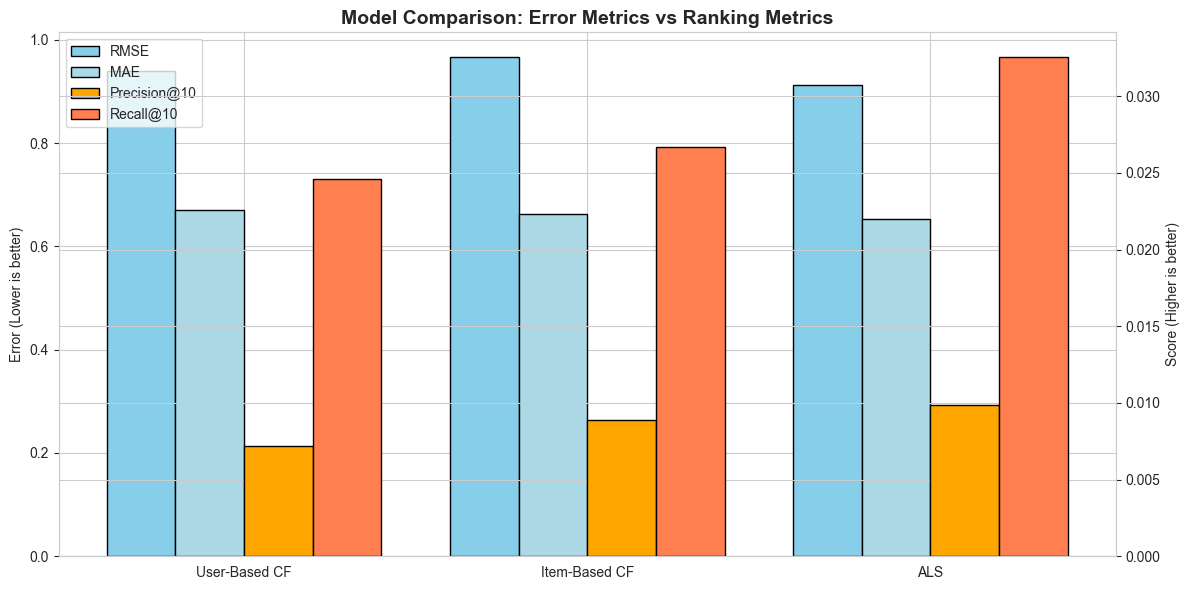


--- Demo Recommendation (ALS Model) ---
User ID: A100WO06OQR8BQ
Top 5 sản phẩm được gợi ý:
  1. B00639DLV2 (Score: 5.00)
  2. B00AYOHWQW (Score: 5.00)
  3. B00A0IWTDI (Score: 5.00)
  4. B00604MSSC (Score: 5.00)
  5. B00GTC02LA (Score: 5.00)


In [42]:
print("\n--- Model Comparison ---")
results_dict = {'validation': all_results, 'test': all_results} 
plot_model_comparison(results_dict, save_path='../data/processed/model_comparison.png')

print("\n--- Demo Recommendation (ALS Model) ---")
sample_user_id = list(user_to_idx.keys())[0]
print(f"User ID: {sample_user_id}")

recommendations = recommend_for_user(
    sample_user_id, als_preds, train_sparse, 
    idx_to_product, user_to_idx, top_n=5
)

print("Top 5 sản phẩm được gợi ý:")
for i, (prod_id, score) in enumerate(recommendations, 1):
    print(f"  {i}. {prod_id} (Score: {score:.2f})")

### 4. TỔNG KẾT

In [43]:
print("\n" + "="*90)
print(f" BÁO CÁO TỔNG KẾT HIỆU NĂNG MÔ HÌNH (DATASET: VALIDATION)")
print("="*90)
print(f"{'MÔ HÌNH':<30} {'RMSE':<10} {'MAE':<10} {'P@10':<10} {'R@10':<10} {'F1@10':<10}")
print("-" * 90)

best_model_rmse = None
best_rmse = float('inf')
best_model_f1 = None
best_f1 = -1

for res in all_results:
    # Chỉ lấy kết quả trên tập validation để so sánh công bằng
    if res['dataset'] == 'validation':
        model_name = res['model']
        rmse = res['rmse']
        mae = res['mae']
        p10 = res['precision@10']
        r10 = res['recall@10']
        f1 = res['f1@10']
        
        print(f"{model_name:<30} {rmse:<10.4f} {mae:<10.4f} {p10:<10.4f} {r10:<10.4f} {f1:<10.4f}")
        
        # Tìm mô hình tốt nhất
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_rmse = model_name
        
        if f1 > best_f1:
            best_f1 = f1
            best_model_f1 = model_name

print(f" KẾT LUẬN:")
print(f"   - Mô hình dự đoán sai số thấp nhất (Best RMSE): {best_model_rmse} ({best_rmse:.4f})")
print(f"   - Mô hình gợi ý top-N tốt nhất (Best F1@10):    {best_model_f1} ({best_f1:.4f})")


 BÁO CÁO TỔNG KẾT HIỆU NĂNG MÔ HÌNH (DATASET: VALIDATION)
MÔ HÌNH                        RMSE       MAE        P@10       R@10       F1@10     
------------------------------------------------------------------------------------------
User-Based CF (k=50)           0.9400     0.6710     0.0072     0.0246     0.0111    
Item-Based CF (k=50)           0.9661     0.6624     0.0089     0.0267     0.0134    
ALS (MF)                       0.9129     0.6521     0.0099     0.0325     0.0151    
 KẾT LUẬN:
   - Mô hình dự đoán sai số thấp nhất (Best RMSE): ALS (MF) (0.9129)
   - Mô hình gợi ý top-N tốt nhất (Best F1@10):    ALS (MF) (0.0151)
